In [1]:
!pip -q install datasets transformers accelerate torch torchvision scikit-learn matplotlib wandb

# Dataset Preparation

In [2]:
from datasets import load_dataset

dataset = load_dataset("matthieulel/galaxy10_decals")
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 15962
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1774
    })
})

# Making Classlabel

In [3]:
from datasets import ClassLabel

# Define the class labels in the order of your classes
class_labels = [
    "Disturbed_Galaxies",
    "Merging_Galaxies",
    "Round_Smooth_Galaxies",
    "In-between_Round_Smooth_Galaxies",
    "Cigar_Shaped_Smooth_Galaxies",
    "Barred_Spiral_Galaxies",
    "Unbarred_Tight_Spiral_Galaxies",
    "Unbarred_Loose_Spiral_Galaxies",
    "Edge-on_Galaxies_without_Bulge",
    "Edge-on_Galaxies_with_Bulge"
]

# Create a ClassLabel feature with the class names
class_label = ClassLabel(names=class_labels)

# Update the 'label' column in the 'test' dataset to use ClassLabel
dataset['train'] = dataset['train'].cast_column('label', class_label)
dataset['test'] = dataset['test'].cast_column('label', class_label)

# Check the updated dataset
print(dataset['test'])

Dataset({
    features: ['image', 'label'],
    num_rows: 1774
})


In [4]:
dataset['train'].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Disturbed_Galaxies', 'Merging_Galaxies', 'Round_Smooth_Galaxies', 'In-between_Round_Smooth_Galaxies', 'Cigar_Shaped_Smooth_Galaxies', 'Barred_Spiral_Galaxies', 'Unbarred_Tight_Spiral_Galaxies', 'Unbarred_Loose_Spiral_Galaxies', 'Edge-on_Galaxies_without_Bulge', 'Edge-on_Galaxies_with_Bulge'], id=None)}

In [5]:
example = dataset["train"][3]
example

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 'label': 2}

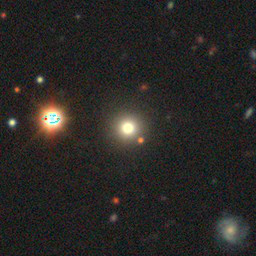

In [6]:
example['image']

In [7]:
model_checkpoint = "google/vit-base-patch16-224" # pre-trained model from which to fine-tune
batch_size = 16
num_epochs = 4

In [8]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [9]:
size = 224

In [10]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
    RandomResizedCrop, ColorJitter
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

train_transforms = Compose([
    RandomResizedCrop(224),
    RandomHorizontalFlip(),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ToTensor(),
])

# train_transforms = Compose(
#         [
#             RandomResizedCrop(size),
#             RandomHorizontalFlip(),
#             ToTensor(),
#             normalize,
#         ]
#     )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def preprocess_test(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        test_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

In [11]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']
test_ds = dataset['test']

In [12]:
print(train_ds.shape)
print(test_ds.shape)
print(val_ds.shape)

(14365, 2)
(1774, 2)
(1597, 2)


In [13]:
len(train_ds)

14365

In [14]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)
test_ds.set_transform(preprocess_val)

In [15]:
train_ds.shape

(14365, 2)

In [16]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 'label': 5,
 'pixel_values': tensor([[[0.2353, 0.2549, 0.1725,  ..., 0.0706, 0.1137, 0.1804],
          [0.2314, 0.2157, 0.1451,  ..., 0.1020, 0.0980, 0.1412],
          [0.2353, 0.1725, 0.0941,  ..., 0.1765, 0.1059, 0.0902],
          ...,
          [0.0275, 0.0667, 0.0706,  ..., 0.1412, 0.0510, 0.0588],
          [0.0431, 0.1725, 0.2235,  ..., 0.1765, 0.2157, 0.2706],
          [0.1137, 0.1804, 0.2706,  ..., 0.1725, 0.2745, 0.3137]],
 
         [[0.0902, 0.0824, 0.1059,  ..., 0.1373, 0.1725, 0.1647],
          [0.1137, 0.1255, 0.1098,  ..., 0.1059, 0.1059, 0.1490],
          [0.2078, 0.1647, 0.0627,  ..., 0.0667, 0.0510, 0.1451],
          ...,
          [0.0667, 0.1490, 0.1647,  ..., 0.0706, 0.0863, 0.1451],
          [0.0588, 0.1333, 0.1412,  ..., 0.1647, 0.1333, 0.1804],
          [0.0706, 0.0471, 0.1137,  ..., 0.1765, 0.1255, 0.1373]],
 
         [[0.0980, 0.0863, 0.1059,  ..., 0.1804, 0.1922, 0.1725],
    

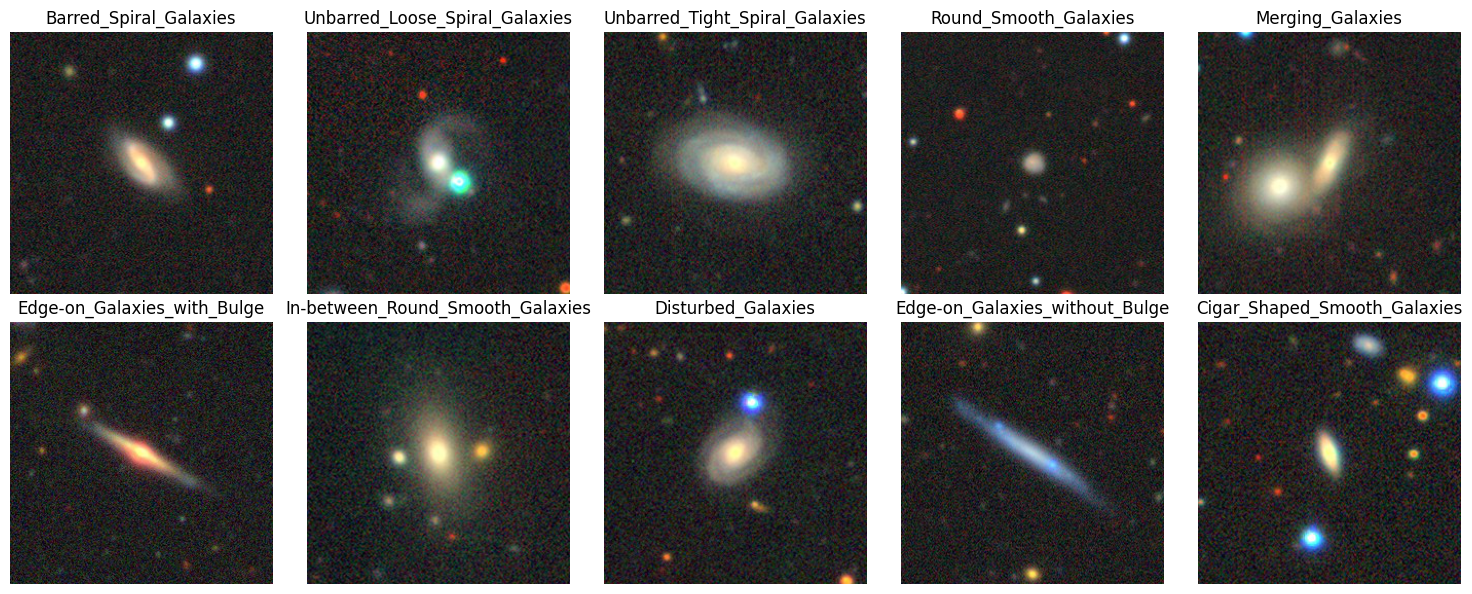

In [17]:
import matplotlib.pyplot as plt

# Initialize a set to keep track of shown labels
shown_labels = set()

# Create a figure with 2 rows and 5 columns
plt.figure(figsize=(15, 6))

# Loop through the dataset and plot the first image of each label
for i, sample in enumerate(train_ds):
    label = train_ds.features["label"].names[sample["label"]]
    if label not in shown_labels:
        # Determine the row and column for the current image
        row = len(shown_labels) // 5  # Floor division to determine row
        col = len(shown_labels) % 5   # Modulo to determine column

        # Create a subplot in the appropriate position (2 rows, 5 columns)
        plt.subplot(2, 5, len(shown_labels) + 1)
        plt.imshow(sample["image"])
        plt.title(label)
        plt.axis("off")
        
        # Add label to the shown labels set
        shown_labels.add(label)
        
        # Break the loop once all labels are shown
        if len(shown_labels) == len(train_ds.features["label"].names):
            break

# Adjust layout to avoid overlap and show the plot
plt.tight_layout()
plt.show()

In [18]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[0]

'Disturbed_Galaxies'

In [19]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
device

device(type='cuda')

# Initialize the model

In [21]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer, EarlyStoppingCallback

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
for param in model.parameters():
    param.requires_grad = True

# Define training arguments

In [23]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-galaxy-identification",  # Output directory for model
    save_total_limit=2,
    report_to="none",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=4,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="logs",
    remove_unused_columns=False,
    #resume_from_checkpoint="/kaggle/working/1-finetuned-galaxy-identification/checkpoint-1347",  # Path to checkpoint from epoch 3
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Create the optimizer

In [24]:
#from torch.optim import RMSprop
#from torch.optim import RAdam

from torch.optim import AdamW


In [25]:
optimizer = AdamW(
    model.parameters(), 
    lr=2e-5, 
    weight_decay=0.01)

In [26]:
total_steps = (len(train_ds) // batch_size) * num_epochs

In [27]:
from transformers import get_scheduler
lr_scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=total_steps
)


In [28]:
!pip -q install evaluate

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [29]:
import evaluate

metric = evaluate.load("accuracy")

In [30]:
import numpy as np

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [31]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [32]:
from torch.nn import CrossEntropyLoss
loss_fn = CrossEntropyLoss(label_smoothing=0.1)

# Initialize the Trainer with the compute_metrics function

In [33]:
# Define a custom Trainer class
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # Get the model outputs and true labels
        outputs = model(**inputs)
        logits = outputs.logits
        labels = inputs.get("labels")
        
        # Initialize CrossEntropyLoss with label smoothing
        loss_fn = CrossEntropyLoss(label_smoothing=0.1)
        
        # Compute the loss
        loss = loss_fn(logits, labels)
        
        if return_outputs:
            return loss, outputs
        return loss

In [34]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Early stopping callback
    optimizers=(optimizer, None) 
)

# Train the model

In [35]:
train_results = trainer.train()
#train_results = trainer.train(resume_from_checkpoint="/kaggle/working/1-finetuned-galaxy-identification/checkpoint-1347")

Epoch,Training Loss,Validation Loss,Accuracy
1,1.088700,0.666180,0.784596
2,0.699000,0.577726,0.800877
3,0.610300,0.556635,0.815279
4,0.546500,0.561253,0.810269


# **Download**

In [36]:
import shutil

# Path to the directory you want to compress
directory_to_zip = "/kaggle/working/vit-large-patch16-224-finetuned-galaxy-identification"

# Path for the output ZIP file
output_zip_path = "/kaggle/working/vit-large-patch16-224-finetuned-galaxy-identification.zip"

# Compress the directory into a ZIP file
shutil.make_archive(base_name=output_zip_path.replace(".zip", ""), format="zip", root_dir=directory_to_zip)


'/kaggle/working/vit-large-patch16-224-finetuned-galaxy-identification.zip'

In [37]:
import os
# Verify the output
print(os.listdir("/kaggle/working"))

['vit-large-patch16-224-finetuned-galaxy-identification.zip', '.virtual_documents', '1-finetuned-galaxy-identification', 'vit-base-patch16-224-finetuned-galaxy-identification']


In [38]:
from IPython.display import FileLink

# Generate a download link for the ZIP file
FileLink("/kaggle/working/vit-large-patch16-224-finetuned-galaxy-identification.zip")


/kaggle/working/vit-large-patch16-224-finetuned-galaxy-identification.zip

In [39]:
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 4147187795GF
  train_loss               =       0.7013
  train_runtime            =   0:26:49.09
  train_samples_per_second =        35.71
  train_steps_per_second   =        2.232


In [40]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

{'test_loss': 0.5706227421760559, 'test_accuracy': 0.8083427282976324, 'test_runtime': 21.831, 'test_samples_per_second': 81.261, 'test_steps_per_second': 20.338}


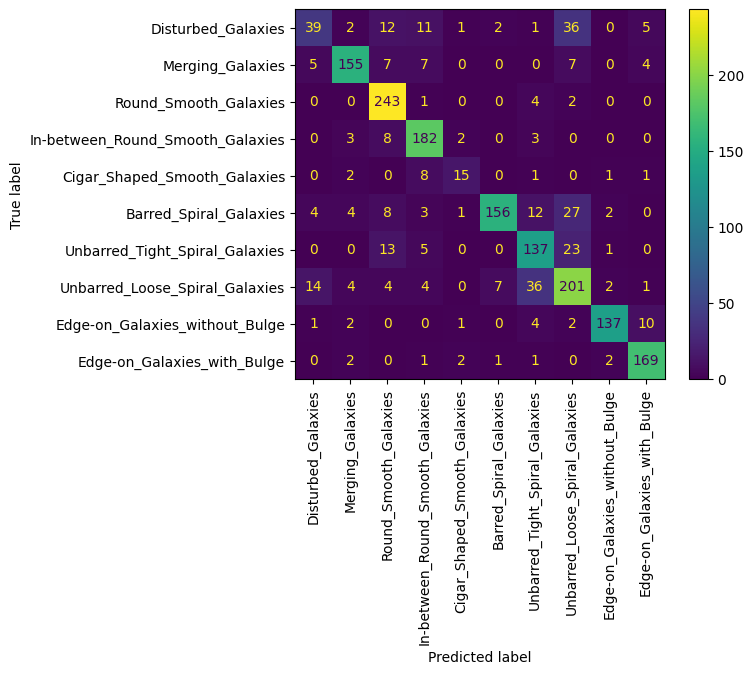

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90)

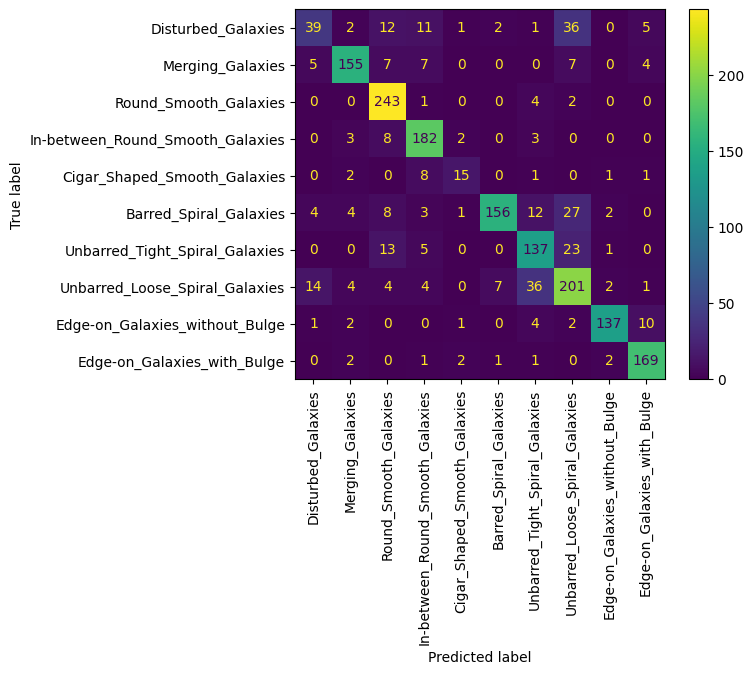

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90)